In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import piecewise_regression
from sklearn.linear_model import LinearRegression
import warnings          #ignore warnings
warnings.filterwarnings("ignore")
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

In [14]:
def plot_data(data_list, plot_stress_strain=True, cutoff_load_thickness=1, cutoff_load_displacement=2):
    """
    Function to plot either stress-strain or load-displacement graphs, and calculates thickness for both cases.

    Parameters:
    - data_list: List of datasets (Pandas DataFrames) to be plotted.
    - plot_stress_strain: Boolean indicating whether to plot stress-strain (True) or load-displacement (False).
    - cutoff_load_thickness: Load cutoff value for determining thickness.
    - cutoff_load_displacement: Load cutoff value for filtering data in the plot.

    Returns:
    - Plots the desired graph based on the provided parameters.
    """

    # Calculate thickness for both cases
    thickness_list = []
    for i in range(len(data_list)):
        # Convert 'S:LVDT (in)' to 'S:LVDT (um)'
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000
        # Determine thickness by subtracting 0 by 'S:LVDT (um)' at cutoff load
        thickness = -data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > cutoff_load_thickness].iloc[0]
        thickness_list.append(thickness)

    if plot_stress_strain:
        # Stress-Strain plot preparation
        plt.figure(figsize=(8, 6))
        for i, data in enumerate(data_list):
            # Create stress and strain columns
            data['stress (bar)'] = data['Ch:Load (N)'] / 19.635 * 10
            data['strain'] = data['S:LVDT (um)'] / thickness_list[i]
            # Filter data above cutoff load
            data = data[data['Ch:Load (N)'] > cutoff_load_displacement]
            # Shift strain data
            data['strain'] = data['strain'] - data['strain'].iloc[0]
            data_name = f"{namestr(data_list[i], globals())} ({thickness_list[i]:.2f} um)"
            plt.plot(data['strain'], data['stress (bar)'], label=data_name)

        plt.title('Stress-Strain Plot')
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

    else:
        # Load-Displacement plot preparation
        plt.figure(figsize=(8, 6))
        for i in range(len(data_list)):
            # Filter data above cutoff load
            data = data_list[i][data_list[i]['Ch:Load (N)'] > cutoff_load_displacement]
            # Shift displacement data
            data['S:LVDT (um)'] = data['S:LVDT (um)'] - data['S:LVDT (um)'].iloc[0]
            data_name = f"{namestr(data_list[i], globals())} ({thickness_list[i]:.2f} um)"
            plt.plot(data['S:LVDT (um)'], data['Ch:Load (N)'], label=data_name)

        plt.title('Load-Displacement Plot')
        plt.xlabel('Displacement (um)')
        plt.ylabel('Load (N)')
        plt.legend(loc='upper left')
        plt.show()



In [22]:
#KNOWLEDGE EXTRACTION PIPELINE CODE
'''
use interpretData and extract function for each batch of trials
use propertyDataFile once all batches are interpreted to create a useable csv file
'''

#IMPORTED PYTHON PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import piecewise_regression
from sklearn.linear_model import LinearRegression
import warnings          #ignore warnings
warnings.filterwarnings("ignore")

def namestr(obj, namespace):          #read the file name of data
    return [name for name in namespace if namespace[name] is obj][0]

#EXTRACT KNOWLEDGE OF A DATA BATCH
def interpretData(data_list, thickness_info = True, thickness_list = None, concentration_info = True, concentration = None, cutoff_load_thickness=1, cutoff_load_displacement=2):
    '''
    Returns mechanical properties of a data batch as a list

    Parameters
    -----
    data_list : list including all the trials read as dataframes
    thickness_info : is True if thickness_list provided and accurate
    thickness_list : if needed, provide manually calculated thickness information
    concentration_true : is True if concentration provided and accurate
    conentration : if needed, provide manually measured concentration

    Returns
    -----
    list - [concentration, heating/no heating, mechanical property dictionaries for each trial]

    see Draft1DerivativeKnowledgeExtraction_AimeeTai.ipynb for example
    '''
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000

    #retrieves thickness information
    thickness = []
    if thickness_info:
        thickness = thickness_list
    else:
        for i in range(len(data_list)):
            thickness.append(-data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > cutoff_load_thickness].iloc[0])

    #retrieves concentration information
    data_name = namestr(data_list[0], globals())
    if concentration_info == True:
        conc = concentration
    else:
        conc = data_name.split('_')[2]
        if len(conc) > 2:
            conc = conc[:-2]

    #retrieves heating information
    if data_name.split('_')[1] == 'heating':
        heating = True
    else:
        heating = False

    #add concentration and heating to returned list
    mechanicalProperties = [float(conc), heating]
    
    #set up stress strain curve
    for i in range(len(data_list)): 
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000     #convert in to um
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10      #create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]      #create strain column which is displacement / thickness, the thickness is shown above
    plt.figure(figsize=(8, 6))

    #set up for loop for each trial in the batch
    for i in range(len(data_list)):
        #retrieve trial name
        data_name = namestr(data_list[i], globals())
        trial = data_name.split('_')[2:]
        if len(trial[0]) > 2:
            trial[0] = trial[0][:-2]
        trial = '_'.join(trial)

        #adjust data for interpretation
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cutoff_load_displacement]      
        data['strain'] = data['strain'] - data['strain'].iloc[0]     #shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data = data.reset_index(drop=True)     #resets indexing
        fracture_index = data['stress (bar)'].idxmax()     #find index of fracture point
        fracture_index += 1
        data = data.iloc[:fracture_index]     #remove datapoints after fracture point

        #plot original data
        plt.scatter(data['strain'], data['stress (bar)'], color='lightgrey', label=data_name)

        #generate spline model
        gam = LinearGAM(s(0))
        gam.fit(data[['strain']], data['stress (bar)'])
        predictions = gam.predict(data[['strain']])
        #print(gam.summary())
        plt.plot(data[['strain']], predictions, color='black',label='Spline Model')

        #calculate derivative of spline model
        data['1st derivative'] = np.gradient(predictions, data['strain'])
        data['2nd derivative'] = np.gradient(data['1st derivative'], data['strain'])

        #identify the elastic region
        data['2nd derivative'].idxmin()     #found the minimum of the 2nd derivative         
        breakpoint1 = data['strain'][data['2nd derivative'].idxmin()]
        #yieldStrength = data['stress (bar)'][data['2nd derivative'].idxmin()]
        #plt.scatter(changepoint1, yieldStrength, color='black', label='Change Point 1')
        elasticRegion = data[data['strain'] <= breakpoint1]

        #calculate the elastic modulus and yield strength
        modelElastic = LinearRegression()
        modelElastic.fit(elasticRegion['strain'].values.reshape(-1, 1), elasticRegion['stress (bar)'].values)
        elasticModulus = modelElastic.coef_[0]
        yieldStrength = modelElastic.predict(breakpoint1.reshape(1,-1))
        predElastic = modelElastic.predict(elasticRegion[['strain']])

        #identify the plateau & densification region
        regions = data[data['strain'] >= breakpoint1]
        pw_fit = piecewise_regression.Fit(list(regions['strain']), list(regions['stress (bar)']), n_breakpoints=4)
        pw_results = pw_fit.get_results()
        eval = None
        if pw_results['estimates'] != None:
            breakpoint2 = pw_results['estimates']['breakpoint1']['estimate']
            breakpoint3 = pw_results['estimates']['breakpoint4']['estimate']
            plateauRegion = regions[regions['strain'] <= breakpoint2]
            densificationRegion = regions[regions['strain'] >= breakpoint3]

            #calculate the plateau region slope
            modelPlateau = LinearRegression()
            modelPlateau.fit(plateauRegion['strain'].values.reshape(-1, 1), plateauRegion['stress (bar)'].values)
            slopePlateau = modelPlateau.coef_[0]
            interceptPlateau = modelPlateau.intercept_

            #calculate the densification region slope
            modelDensification = LinearRegression()
            modelDensification.fit(densificationRegion['strain'].values.reshape(-1, 1), densificationRegion['stress (bar)'].values)
            slopeDensification = modelDensification.coef_[0]
            interceptDensification = modelDensification.intercept_

            #calculate the changepoint between the plateau and densification region
            changepoint = (interceptDensification - interceptPlateau) / (slopePlateau - slopeDensification)
            xPlateau = data[(breakpoint1 <= data['strain']) & (data['strain'] <= changepoint)]
            xDensification = data[changepoint <= data['strain']]
            if len(xDensification) > 0 and len(xPlateau) > 0:
                predPlateau = modelPlateau.predict(xPlateau[['strain']])
                predDensification = modelDensification.predict(xDensification[['strain']])

                #evaluate fit
                plateauModel = LinearGAM(s(0))
                plateauModel.fit(xPlateau[['strain']], xPlateau['stress (bar)'])
                plateauSpline = plateauModel.predict(xPlateau[['strain']])

                correlation_coefficient = np.corrcoef(plateauSpline, predPlateau)[0, 1]

                #ensure the linear models align with each other
                rangeStart = yieldStrength - 3     #arbitrary range
                rangeEnd = yieldStrength + 3
                if rangeStart <= modelPlateau.predict(breakpoint1.reshape(1, -1)) <= rangeEnd and slopePlateau <= elasticModulus*1.25 and correlation_coefficient <= 0.98:
                    eval = True
                else:
                    eval = False

                #dictionary of each trial's mechanical properties
                dict = {'Trial': trial,
                        "Thickness": thickness[i],
                        "Elastic Modulus":elasticModulus, 
                        "Yield Strength":yieldStrength[0], 
                        "Changepoint":changepoint, 
                        "Slope Plateau":slopePlateau, 
                        "Slope Densification":slopeDensification,
                        "Good Fit":eval}
                mechanicalProperties.append(dict)

                #plotted linear models of each region
                plt.plot(elasticRegion['strain'], predElastic, color='blue',  label='Elastic Region')
                plt.plot(xPlateau['strain'], predPlateau, color='orange', label="Plateau Region")
                plt.plot(xDensification['strain'], predDensification, color='green', label="Densification Region")
        
        plt.title(data_name)
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

        print("Good Fit:", eval)

    return mechanicalProperties

#ADD DATA TO A GLOABL LIST
def extract(materialProperties):  
    '''
    adds data from the interpretData function list to global lists

    Parameters
    -----
    materialProperties : the returned list of the interpretData function

    Returns
    -----
    none

    NEEDS EMPTY GLOBAL LISTS IN CODE BEFORE USE
    '''
    for i in range(2,len(materialProperties)):
        thickness.append(materialProperties[i]['Thickness'])
        conc.append(materialProperties[0])
        heating.append(materialProperties[1])
        trial_number.append(materialProperties[i]['Trial'])
            
        elasticModulus.append(materialProperties[i]['Elastic Modulus'])
        yieldStrength.append(materialProperties[i]['Yield Strength'])
        slopePlateau.append(materialProperties[i]['Slope Plateau'])
        slopeDensification.append(materialProperties[i]['Slope Densification'])
        changepoint.append(materialProperties[i]['Changepoint'])
        fit.append(materialProperties[i]["Good Fit"])

#necessary global lists
thickness = []
elasticModulus = []
yieldStrength = []
slopePlateau = []
slopeDensification = []
changepoint = []
fit = []
conc = []
heating = []
trial_number = []

#CREATE PROPERTY DATA CSV FILE
def propertyDataFile():
    '''
    creates property_data.csv from global lists of the material properties from the extract and interpretData function
    '''
    propertyData = {'Trial':trial_number,
                    'Concentration':conc, 
                    'Heating': heating,
                    'Thickness': thickness,
                    'Elastic Modulus': elasticModulus,
                    'Yield Strength': yieldStrength,
                    'Plateau Slope': slopePlateau,
                    'Densification Slope': slopeDensification,
                    'Changepoint': changepoint,
                    'Fit':fit}

    propertyData = pd.DataFrame(propertyData)
    propertyData = propertyData.sort_values('Concentration')
    propertyData.to_csv('property_data.csv', index=False)

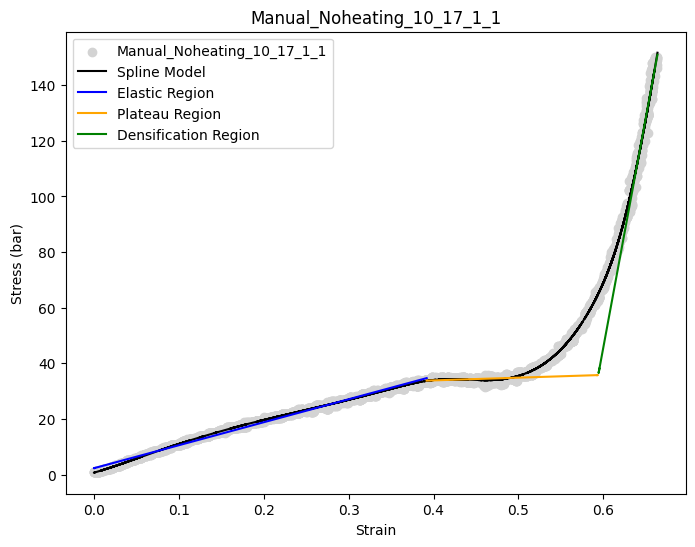

Good Fit: True


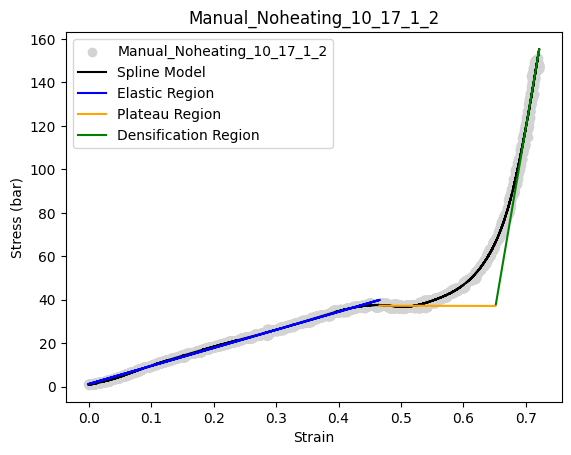

Good Fit: True


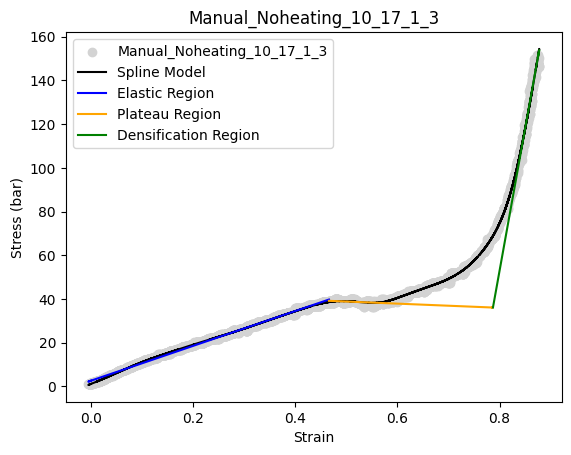

Good Fit: True


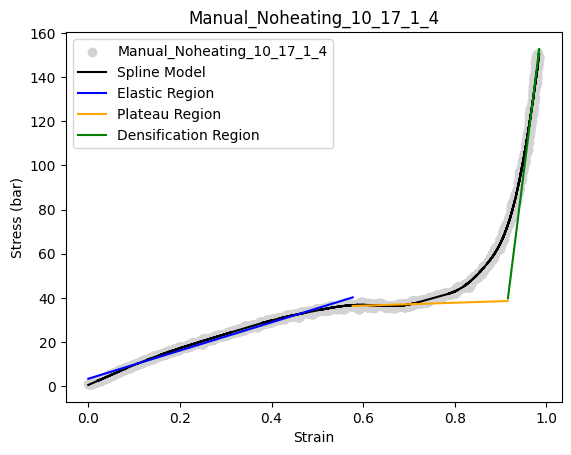

Good Fit: False


[10.0,
 False,
 {'Trial': '10_17_1_1',
  'Thickness': 132.7404,
  'Elastic Modulus': 82.50902778126179,
  'Yield Strength': 34.67603327396631,
  'Changepoint': 0.5942680040375201,
  'Slope Plateau': 9.810131457016988,
  'Slope Densification': 1647.3488076062897,
  'Good Fit': True},
 {'Trial': '10_17_1_2',
  'Thickness': 133.83259999999999,
  'Elastic Modulus': 82.94492762367113,
  'Yield Strength': 39.90892498998723,
  'Changepoint': 0.6516456659556928,
  'Slope Plateau': -0.5318520024304011,
  'Slope Densification': 1688.876506282948,
  'Good Fit': True},
 {'Trial': '10_17_1_3',
  'Thickness': 130.65759999999997,
  'Elastic Modulus': 79.75923406397378,
  'Yield Strength': 39.70999473229179,
  'Changepoint': 0.7871257975570423,
  'Slope Plateau': -9.57999530618668,
  'Slope Densification': 1301.2806987294248,
  'Good Fit': True},
 {'Trial': '10_17_1_4',
  'Thickness': 126.36500000000001,
  'Elastic Modulus': 63.77644641191553,
  'Yield Strength': 40.24506611059252,
  'Changepoint': 0.

In [23]:
Manual_Noheating_10_17_1_1 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-1-1_09062024_164958.csv')
Manual_Noheating_10_17_1_2 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-1-2_09062024_165354.csv')
Manual_Noheating_10_17_1_3 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-1-3_09062024_165746.csv')
Manual_Noheating_10_17_1_4 = pd.read_csv('Data/compression 17/ManualNoHeating-10-17-reverse-hand-1-4_09062024_170120.csv')

data_list = [Manual_Noheating_10_17_1_1, Manual_Noheating_10_17_1_2, Manual_Noheating_10_17_1_3, Manual_Noheating_10_17_1_4]

interpretData(data_list, thickness_info = False, concentration_info = True, concentration = 10, cutoff_load_thickness=1, cutoff_load_displacement=2)